# **1. Importing Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#display를 가져와서 이미지 표시
from IPython.display import Image

#바로 그림을 볼 수 있게 해줌 (외부 창이 아니라 내부 창(in Jupyter notebook))
%matplotlib inline
import seaborn as sns

#여러 색깔 표현 (cmap)
from matplotlib import cm

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#문서에서 단어의 수를 세어줌
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix, classification_report, roc_curve

# **2. Exploratory Data Analysis**

In [ ]:
labels = ['G protein coupled receptors', 'Tyrosine Kinase', 'Tyrosine phosphatase', 'Synthetase', 'Synthase', 'Ion channel', 'Transcription Factor']

In [ ]:
from google.colab import files
files.upload()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
human_data = pd.read_table('human_data.txt')
human_data.head()

,sequence,class
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3


In [ ]:
human_data.info()
#하나의 열이 하나의 DNA
#class는 무슨 단백질인지 알려줌
#한 사람에 대한 데이터임

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4380 entries, 0 to 4379
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sequence  4380 non-null   object
 1   class     4380 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 68.6+ KB


In [ ]:
human_data.describe()

,class
count,4380.000000
mean,3.504566
std,2.132134
min,0.000000
25%,2.000000
50%,4.000000
75%,6.000000
max,6.000000


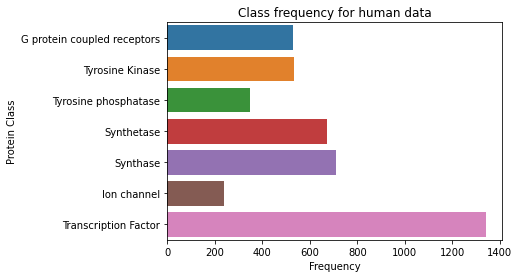

In [ ]:
#sort_index는 컬럼을 이름 순(1,2,3,....)으로 정렬, 정렬하지 않으면 크기 순으로 나와서 label과 맞지 않음
#이때 이 정렬한 값은 labels안에 있는 값들의 순서와 같다.
sns.barplot(x=human_data['class'].value_counts().sort_index(), y=labels)
plt.title("Class frequency for human data")
plt.xlabel("Frequency")
plt.ylabel("Protein Class")
plt.show()

인간 DNA안에 있는 단백질

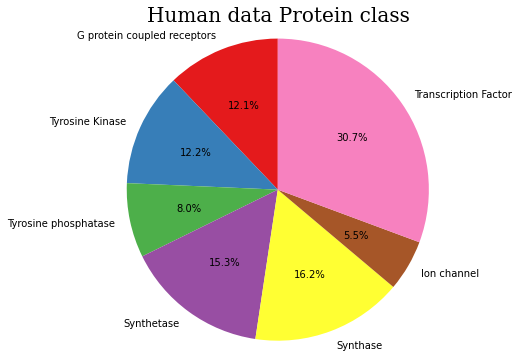

In [ ]:
plt.figure(figsize=(6,6))
font_dict = font = {'family':'serif', 'color':'Black', 'weight':'normal', 'size':20}
a = np.random.random(7)
cs = cm.Set1(np.arange(7)/7.)
#autopct는 차트에 표시될 단위, startangle는 시작 각도(반시계 방향으로 진행)(x축 양의 방향 기준)
plt.pie(human_data['class'].value_counts().sort_index(), labels = labels, autopct='%1.1f%%',colors = cs, startangle=90)
#축의 범위와 스케일 동일하게
plt.axis('equal')
plt.title('Human data Protein class',fontdict=font_dict)
plt.show()

In [ ]:
#침팬지 데이터
from google.colab import files
files.upload()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
chimp_data = pd.read_table('chimp_data.txt')
chimp_data.head()

,sequence,class
0,ATGCCCCAACTAAATACCGCCGTATGACCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTATTCGCTTCATTCGCTGCCCCCACAATCCTAG...,4
2,ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...,4
3,ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...,4
4,ATGGGCAGCGCCAGCCCGGGTCTGAGCAGCGTGTCCCCCAGCCACC...,6


In [ ]:
chimp_data.describe()

,class
count,1682.000000
mean,3.491082
std,2.177486
min,0.000000
25%,2.000000
50%,4.000000
75%,6.000000
max,6.000000


In [ ]:
chimp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sequence  1682 non-null   object
 1   class     1682 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 26.4+ KB


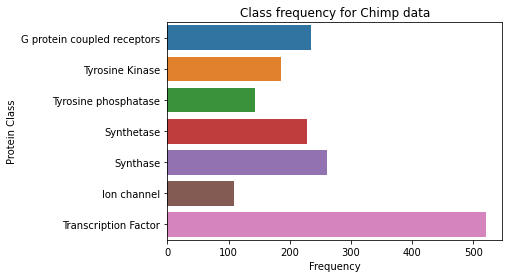

In [ ]:
sns.barplot(x = chimp_data['class'].value_counts().sort_index(), y=labels)
plt.title("Class frequency for Chimp data")
plt.xlabel("Frequency")
plt.ylabel("Protein Class")
plt.show()

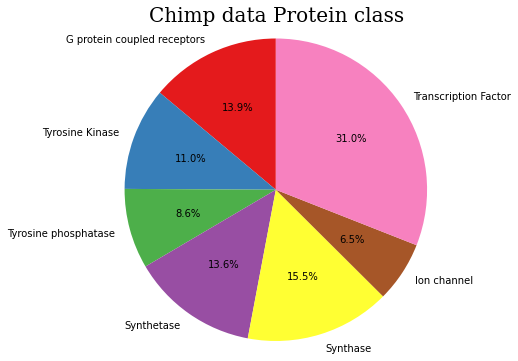

In [ ]:
plt.figure(figsize=(6,6))
font_dict = font = {'family':'serif', 'color':'Black', 'weight':'normal', 'size':20}
a = np.random.random(7)
cs = cm.Set1(np.arange(7)/7.)
#autopct는 차트에 표시될 단위, startangle는 시작 각도(반시계 방향으로 진행)(x축 양의 방향 기준)
plt.pie(chimp_data['class'].value_counts().sort_index(), labels = labels, autopct='%1.1f%%',colors = cs, startangle=90)
#축의 범위와 스케일 동일하게
plt.axis('equal')
plt.title('Chimp data Protein class',fontdict=font_dict)
plt.show()

# **3. Model Development**

# **(a) - Human Data**

In [ ]:
#문자열을 돌면서 size만큼 단어를 잘라서 반환함
def getKmers(sequence, size = 6):
  return [sequence[x:x+size].lower() for x in range(len(sequence)-size +1)]

# 최소 4단어, 최대 4단어 즉, 4단어를 한 덩어리로 봄
cv = CountVectorizer(ngram_range=(4,4))

In [ ]:
#axis=1로 주어 행방향으로 적용, x는 하나의 행을 가리킴, sequence열에 있는 단어들을 분해
human_data['words'] = human_data.apply(lambda x: getKmers(x['sequence']),axis =1)
human_data.drop('sequence',axis =1,inplace=True)
human_data

,class,words
0,4,"[atgccc, tgcccc, gcccca, ccccaa, cccaac, ccaac..."
1,4,"[atgaac, tgaacg, gaacga, aacgaa, acgaaa, cgaaa..."
2,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
3,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
4,3,"[atgcaa, tgcaac, gcaaca, caacag, aacagc, acagc..."
...,...,...
4375,0,"[atggaa, tggaag, ggaaga, gaagat, aagatt, agatt..."
4376,6,"[atgcag, tgcagt, gcagtc, cagtcc, agtcct, gtcct..."
4377,6,"[atgcag, tgcagt, gcagtc, cagtcc, agtcct, gtcct..."
4378,6,"[atgggg, tggggc, ggggca, gggcac, ggcacc, gcacc..."


In [ ]:
#human_data['words']에 있는 모든 단어들을 list에 저장(중복 o)
#이때 human_texts는 2차원 배열로 길이는 human_data의 길이와 같다.
human_texts = list(human_data['words'])
for item in range(len(human_data)):
  #human_texts[item]에 있는 모든 원소들을 띄어쓰기 하나로 구분하여 이어붙임
  human_texts[item] = " ".join(human_texts[item])

In [ ]:
#CountVectorizer은 문장에서 단어의 수를 세어준다
#긴 염기서열을 이어붙인 문장에서 각 염기서열이 몇 개인지 세어준다.
x_human = cv.fit_transform(human_texts)
y_human = human_data.iloc[:,0].values

In [ ]:
print(x_human.shape, y_human.shape)

(4380, 232414) (4380,)


In [ ]:
human_texts[1]

'atgaac tgaacg gaacga aacgaa acgaaa cgaaaa gaaaat aaaatc aaatct aatctg atctgt tctgtt ctgttc tgttcg gttcgc ttcgct tcgctt cgcttc gcttca cttcat ttcatt tcattc cattca attcat ttcatt tcattg cattgc attgcc ttgccc tgcccc gccccc ccccca ccccac cccaca ccacaa cacaat acaatc caatcc aatcct atccta tcctag cctagg ctaggc taggcc aggcct ggccta gcctac cctacc ctaccc tacccg acccgc cccgcc ccgccg cgccgc gccgca ccgcag cgcagt gcagta cagtac agtact gtactg tactga actgat ctgatc tgatca gatcat atcatt tcattc cattct attcta ttctat tctatt ctattt tatttc atttcc tttccc ttcccc tccccc ccccct cccctc ccctct cctcta ctctat tctatt ctattg tattga attgat ttgatc tgatcc gatccc atcccc tcccca ccccac cccacc ccacct cacctc acctcc cctcca ctccaa tccaaa ccaaat caaata aaatat aatatc atatct tatctc atctca tctcat ctcatc tcatca catcaa atcaac tcaaca caacaa aacaac acaacc caaccg aaccga accgac ccgact cgacta gactaa actaat ctaatc taatca aatcac atcacc tcacca caccac accacc ccaccc caccca acccaa cccaac ccaaca caacaa aacaat acaatg caatga aatgac atgact tgacta gacta

**Data split**

In [ ]:
from sklearn.model_selection import train_test_split
x_train_human, x_test_human, y_train_human, y_test_human = train_test_split(x_human, y_human, test_size = 0.25, random_state = 42)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtree_human = DecisionTreeClassifier()
dtree_human.fit(x_train_human, y_train_human)
dtree_human_pred = dtree_human.predict(x_test_human)
print("Accuracy for human data using DecisionTree Classifier :", accuracy_score(y_test_human, dtree_human_pred))

Accuracy for human data using DecisionTree Classifier : 0.8082191780821918


In [ ]:
#n_estimators가 올라가면 정확도가 올라가지만 시간이 더 오래걸려
from sklearn.ensemble import RandomForestClassifier
rf_human = RandomForestClassifier(n_estimators = 400)
rf_human.fit(x_train_human,y_train_human)
rf_human_pred = rf_human.predict(x_test_human)
print("Accuracy for human data using RandomForest Classifier :", accuracy_score(y_test_human, rf_human_pred))

Accuracy for human data using RandomForest Classifier : 0.9141552511415525


In [ ]:
import xgboost as xgb
xgb_human = xgb.XGBClassifier()
xgb_human.fit(x_train_human, y_train_human)
xgb_human_pred = xgb_human.predict(x_test_human)
print("Accuracy for human data using XGBoost Classifier :", accuracy_score(y_test_human, xgb_human_pred))

Accuracy for human data using XGBoost Classifier : 0.7844748858447489


In [ ]:
from sklearn.naive_bayes import MultinomialNB
#alpha는 라플라스 스무딩을 위한 변수
NB_human = MultinomialNB(alpha = 0.1)
NB_human.fit(x_train_human, y_train_human)
y_human_pred = NB_human.predict(x_test_human)
print("Accuracy for human data using NB Classifier :", accuracy_score(y_test_human, y_human_pred))

Accuracy for human data using NB Classifier : 0.9780821917808219


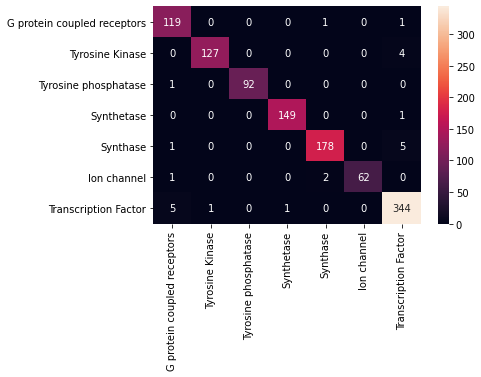

In [ ]:
cm = confusion_matrix(y_test_human, y_human_pred)
#fmt = g => annot가 정수
sns.heatmap(cm, annot = True, xticklabels=labels, yticklabels=labels, fmt='g')
#x는 actual, y는 추정치 

In [ ]:
print(classification_report(y_test_human, y_human_pred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       121
           1       0.99      0.97      0.98       131
           2       1.00      0.99      0.99        93
           3       0.99      0.99      0.99       150
           4       0.98      0.97      0.98       184
           5       1.00      0.95      0.98        65
           6       0.97      0.98      0.97       351

    accuracy                           0.98      1095
   macro avg       0.98      0.98      0.98      1095
weighted avg       0.98      0.98      0.98      1095



# **(b) - Chimpanzee Data**

In [ ]:
chimp_data['words'] = chimp_data.apply(lambda x : getKmers(x['sequence']), axis=1)
chimp_data.drop('sequence', axis = 1, inplace=True)

In [ ]:
chimp_texts = list(chimp_data['words'])
for item in range(len(chimp_texts)):
  chimp_texts[item] = ' '.join(chimp_texts[item])

In [ ]:
chimp_texts[0]

'atgccc tgcccc gcccca ccccaa cccaac ccaact caacta aactaa actaaa ctaaat taaata aaatac aatacc ataccg taccgc accgcc ccgccg cgccgt gccgta ccgtat cgtatg gtatga tatgac atgacc tgaccc gaccca acccac cccacc ccacca caccat accata ccataa cataat ataatt taatta aattac attacc ttaccc tacccc accccc ccccca ccccat cccata ccatac catact atactc tactcc actcct ctcctg tcctga cctgac ctgaca tgacac gacact acacta cactat actatt ctattt tatttc atttct tttctc ttctcg tctcgt ctcgtc tcgtca cgtcac gtcacc tcaccc caccca acccaa cccaac ccaact caacta aactaa actaaa ctaaaa taaaaa aaaaat aaaata aaatat aatatt atatta tattaa attaaa ttaaat taaatt aaattc aattca attcaa ttcaaa tcaaat caaatt aaatta aattac attacc ttacca taccat accatc ccatct catcta atctac tctacc ctaccc tacccc accccc cccccc ccccct cccctc ccctca cctcac ctcacc tcacca caccaa accaaa ccaaaa caaaac aaaacc aaaccc aaccca acccat cccata ccataa cataaa ataaaa taaaaa aaaaat aaaata aaataa aataaa ataaaa taaaaa aaaaaa aaaaac aaaact aaacta aactac actaca ctacaa tacaat acaata caataa aataaa ataaa

In [ ]:
x_chimp = cv.fit_transform(chimp_texts)
y_chimp = chimp_data['class']

scipy.sparse.csr.csr_matrix

In [ ]:
from sklearn.model_selection import train_test_split
x_train_chimp, x_test_chimp, y_train_chimp, y_test_chimp = train_test_split(x_chimp, y_chimp, test_size = 0.25, random_state = 42)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtree_chimp = DecisionTreeClassifier()
dtree_chimp.fit(x_train_chimp, y_train_chimp)
dtree_chimp_pred = dtree_chimp.predict(x_test_chimp)
print("Accuracy for chimp data using DecisionTree Classifier :", accuracy_score(y_test_chimp, dtree_chimp_pred))

Accuracy for chimp data using DecisionTree Classifier : 0.7482185273159145


In [ ]:
#n_estimators가 올라가면 정확도가 올라가지만 시간이 더 오래걸려
from sklearn.ensemble import RandomForestClassifier
rf_chimp = RandomForestClassifier(n_estimators = 400)
rf_chimp.fit(x_train_chimp,y_train_chimp)
rf_chimp_pred = rf_chimp.predict(x_test_chimp)
print("Accuracy for chimp data using RandomForest Classifier :", accuracy_score(y_test_chimp, rf_chimp_pred))

Accuracy for chimp data using RandomForest Classifier : 0.8266033254156769


In [ ]:
import xgboost as xgb
xgb_chimp = xgb.XGBClassifier()
xgb_chimp.fit(x_train_chimp, y_train_chimp)
xgb_chimp_pred = xgb_chimp.predict(x_test_chimp)
print("Accuracy for chimp data using XGBoost Classifier :", accuracy_score(y_test_chimp, xgb_chimp_pred))

Accuracy for chimp data using XGBoost Classifier : 0.7862232779097387


In [ ]:
from sklearn.naive_bayes import MultinomialNB
#alpha는 라플라스 스무딩을 위한 변수
NB_chimp = MultinomialNB(alpha = 0.1)
NB_chimp.fit(x_train_chimp, y_train_chimp)
y_chimp_pred = NB_chimp.predict(x_test_chimp)
print("Accuracy for chimp data using NB Classifier :", accuracy_score(y_test_chimp, y_chimp_pred))

Accuracy for chimp data using NB Classifier : 0.8978622327790974


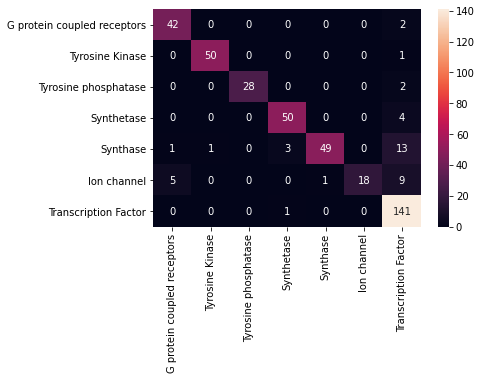

In [ ]:
cm = confusion_matrix(y_test_chimp, y_chimp_pred)
sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, fmt = 'g')
#x축은 actual, y축은 예측

In [ ]:
print(classification_report(y_test_chimp, y_chimp_pred))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91        44
           1       0.98      0.98      0.98        51
           2       1.00      0.93      0.97        30
           3       0.93      0.93      0.93        54
           4       0.98      0.73      0.84        67
           5       1.00      0.55      0.71        33
           6       0.82      0.99      0.90       142

    accuracy                           0.90       421
   macro avg       0.94      0.87      0.89       421
weighted avg       0.91      0.90      0.89       421



# **학습시킨 모델을 파일로 저장하기/불러오기**

In [ ]:
#저장하기

import pickle
filename = 'human_data_NB1.pk1'
#쓰기는 wb, 읽기는 rb
model_pk1 = open(filename, 'wb')
#첫 인자는 모델, 두 번째 인자는 open
pickle.dump(NB_human, model_pk1)
model_pk1.close()

filename = 'chimp_data_NB1.pk1'
#쓰기는 wb, 읽기는 rb
model_pk1 = open(filename, 'wb')
#첫 인자는 모델, 두 번째 인자는 open
pickle.dump(NB_chimp, model_pk1)
model_pk1.close()


In [ ]:
#불러오기

import pickle
human_pk1 = open('human_data_NB1.pk1','rb')
humanmode1 = pickle.load(human_pk1)

import pickle
chimp_pk1 = open('chimp_data_NB1.pk1','rb')
chimpmode1 = pickle.load(chimp_pk1)

결론 : 둘 다 NB분류기를 사용했을때 가장 정확도가 높았다.

NB는 sequence data작업에 적합하다. 

(나열할 수 있는 일련의 데이터)